# LSTM(Long Short-Term Memory) 구조

<img src = "./image/rnn_lstm.jpg" width = 500 height = 500>

- 단기 기억을 오래하기 위해 고안되었음

<img src = "./image/lstm.png" width = 500 height = 500>

- 은닉 상태를 만드는 방법
    - output gate layer(출력 게이트)
        1. 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만듦
            - 이 때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용
        2. tanh 활성화 함수를 통과한 값과 곱해져서 은닉 상태를 만듦
        
- LSTM은 순환되는 상태가 2개
    - 은닉 상태
    - 셀 상태(cell state)
        - 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값
        
- 셀 상태를 계산하는 과정
    - forget gate layer(삭제 게이트)
        - 정보를 제거하는 역할
        1. 입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과
        2. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만듦
            - 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여
            
    - input gate layer(입력 게이트)
        - 새로운 정보를 셀 상태에 추가
        1. 입력과 은닉 상태를 각기 다른 가중치에 곱함
        2. 하나는 시그모이드 함수, 하나는 tanh 함수를 통과
        3. 두 결과를 곱함
        4. 이전 셀 상태와 더함

# 데이터 준비

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 500)

In [3]:
# 훈련 세트와 검증 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 8)

In [4]:
# 패딩
train_seq = pad_sequences(x_train, maxlen = 100)
val_seq = pad_sequences(x_val, maxlen = 100)

In [6]:
# LSTM 모델 생성
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


- LSTM셀 파라미터 개수
    - ((8 * 8) + (16 * 8) + 8) * 4 = 800

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [9]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 64, validation_data = (val_seq, y_val),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6925 - accuracy: 0.5310 - val_loss: 0.6915 - val_accuracy: 0.5678
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6898 - accuracy: 0.6065 - val_loss: 0.6877 - val_accuracy: 0.6246
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6821 - accuracy: 0.6545 - val_loss: 0.6740 - val_accuracy: 0.6710
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6443 - accuracy: 0.6974 - val_loss: 0.6111 - val_accuracy: 0.7008
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.5935 - accuracy: 0.7089 - val_loss: 0.5847 - val_accuracy: 0.7154
Epoch 6/100
313/313 [==============================] - 8s 27ms/step - loss: 0.5686 - accuracy: 0.7307 - val_loss: 0.5656 - val_accuracy: 0.7328
Epoch 7/100
313/313 [==============================] - 8s 26ms/step - loss: 0.5469 - accuracy: 0.7487 - val_loss: 0.5470 - val_accuracy:

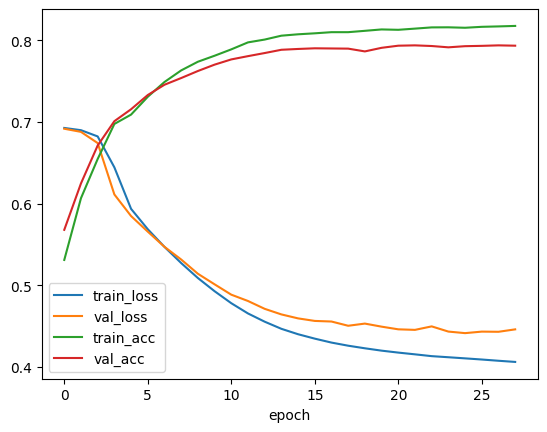

In [10]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 순환층에 드롭아웃 적용

- 순환층은 자체적으로 드롭아웃 기능을 제공
    - SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음
        - dropout : 셀의 입력에 드롭아웃을 적용 (입력데이터의 일부를 0으로 바꾸는...)
            - dropout을 쓰면 val_loss가 loss가 떨어지는 만큼 좀 더 따라간다
        - recurrent_dropout : 순환되는 은닉 상태에 드롭아웃을 적용 (순환하는 일부를 0으로 바꿈)
            - 버전에 따라 recurrent_dropout이 GPU를 사용하지 못하는 경우가 있음

In [6]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))  # 500개 단어를 16개로 표현
model2.add(keras.layers.LSTM(8, dropout = 0.3))
model2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-dropout-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [8]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 64, validation_data = (val_seq, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 22s 57ms/step - loss: 0.6925 - accuracy: 0.5266 - val_loss: 0.6919 - val_accuracy: 0.5584
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6910 - accuracy: 0.5693 - val_loss: 0.6900 - val_accuracy: 0.5862
Epoch 3/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6880 - accuracy: 0.6008 - val_loss: 0.6857 - val_accuracy: 0.6110
Epoch 4/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6795 - accuracy: 0.6359 - val_loss: 0.6716 - val_accuracy: 0.6466
Epoch 5/100
313/313 [==============================] - 16s 53ms/step - loss: 0.6385 - accuracy: 0.6841 - val_loss: 0.6000 - val_accuracy: 0.6926
Epoch 6/100
313/313 [==============================] - 16s 53ms/step - loss: 0.5786 - accuracy: 0.7089 - val_loss: 0.5657 - val_accuracy: 0.7246
Epoch 7/100
313/313 [==============================] - 16s 53ms/step - loss: 0.5519 - accuracy: 0.7358 - val_loss: 0.5419 - val_ac

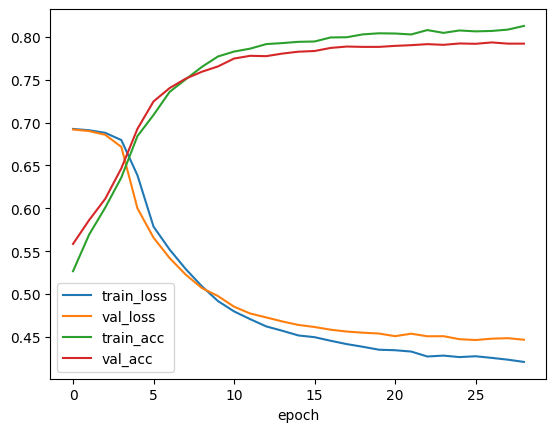

In [9]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 2개의 층을 연결

- 순환층을 연결할 때의 주의점
    - 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달
        - 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요함
        - 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야함
            - return_sequences 매개변수를 True로 지정

In [13]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length = 100))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(8, dropout = 0.3)) # 젤 마지막 lstm은 return_sequences 없어야 함
model3.add(keras.layers.Dense(1, activation = "sigmoid"))

In [14]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_3 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_4 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


- 첫 번째 LSTM
    - 모든 타입스텝(100개)의 은닉 상태를 출력하기 때문에 출력의 크기가 (None, 100, 8)
    
- 두 번째 LSTM
    - 마지막 타임스텝의 은닉 상태만 출력하기 때문에 출력의 크기가 (None, 8)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model3.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-2rnn-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [16]:
history = model3.fit(train_seq, y_train, epochs = 100, batch_size = 64, validation_data = (val_seq, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 40s 105ms/step - loss: 0.6929 - accuracy: 0.5226 - val_loss: 0.6925 - val_accuracy: 0.5524
Epoch 2/100
313/313 [==============================] - 32s 101ms/step - loss: 0.6914 - accuracy: 0.5813 - val_loss: 0.6895 - val_accuracy: 0.6124
Epoch 3/100
313/313 [==============================] - 32s 101ms/step - loss: 0.6777 - accuracy: 0.6317 - val_loss: 0.6491 - val_accuracy: 0.6756
Epoch 4/100
313/313 [==============================] - 32s 101ms/step - loss: 0.6157 - accuracy: 0.6862 - val_loss: 0.5926 - val_accuracy: 0.7060
Epoch 5/100
313/313 [==============================] - 31s 100ms/step - loss: 0.5755 - accuracy: 0.7158 - val_loss: 0.5549 - val_accuracy: 0.7392
Epoch 6/100
313/313 [==============================] - 32s 102ms/step - loss: 0.5426 - accuracy: 0.7405 - val_loss: 0.5326 - val_accuracy: 0.7400
Epoch 7/100
313/313 [==============================] - 32s 103ms/step - loss: 0.5178 - accuracy: 0.7587 - val_loss: 0.5081 -

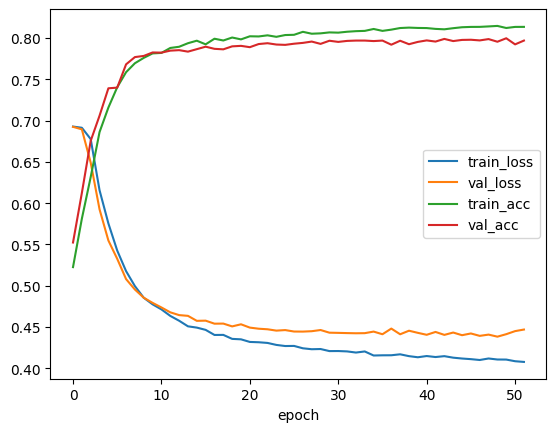

In [17]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# GRU(Grated Recurrent Unit) 구조

<img src = "./image/rnn_lstm_gru.png">

- LSTM을 간소화한 버전
- LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함
- LSTM보다 가중치가 적기 때문에 계산량이 적지만 성능은 LSTM과 유사함
    - 데이터 양이 적을 때는 GRU의 성능이 더 좋고 데이터 양이 많을 때는 LSTM의 성능이 더 좋아지는 경향이 있음
    - GRU와 LSTM 중 어떤 것이 더 낫다라고 말할 수는 없음

<img src = "./image/gru.png" width = 500 height = 500>

- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개가 들어 있음
    - 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용
    
- reset_gate
    - 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행
    
- update_gate
    - 어떤 정보를 얼마만큼 유지하고 어떤 정보를 추가할지 결정하는 역할

In [18]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length = 100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation = "sigmoid"))

In [19]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [20]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-gru-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [21]:
history = model4.fit(train_seq, y_train, epochs = 100, batch_size = 64, validation_data = (val_seq, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6918 - val_accuracy: 0.5478
Epoch 2/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6907 - accuracy: 0.5614 - val_loss: 0.6901 - val_accuracy: 0.5640
Epoch 3/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6881 - accuracy: 0.5807 - val_loss: 0.6873 - val_accuracy: 0.5766
Epoch 4/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6840 - accuracy: 0.5973 - val_loss: 0.6829 - val_accuracy: 0.5866
Epoch 5/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6776 - accuracy: 0.6120 - val_loss: 0.6761 - val_accuracy: 0.5950
Epoch 6/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6681 - accuracy: 0.6244 - val_loss: 0.6661 - val_accuracy: 0.6094
Epoch 7/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6543 - accuracy: 0.6382 - val_loss: 0.6509 - val_accuracy:

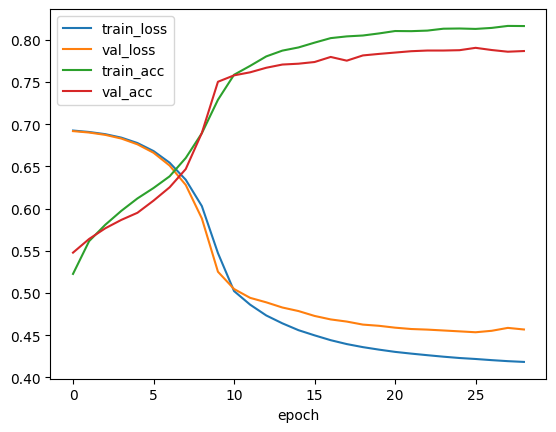

In [22]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# best model 검증

In [23]:
test_seq = pad_sequences(x_test, maxlen = 100)
rnn_model = keras.models.load_model("./model/best-2rnn-model.h5")
rnn_model.evaluate(test_seq, y_test)

782/782 [==============================] - 7s 8ms/step - loss: 0.4202 - accuracy: 0.8045


[0.4202198088169098, 0.8044800162315369]